# Importing Packages and Inicial Data Preview

In [1]:
# Importing packages

import pandas as pd
import numpy as np

import requests
import scipy.stats as stats
from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from category_encoders import LeaveOneOutEncoder

from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from itertools import combinations
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,precision_recall_fscore_support, make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

In [2]:
# loading dataset and handle a subset of it

df = pd.read_csv("US_Accidents_March23_sampled_500k.csv")

In [3]:
df.shape

(500000, 46)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     500000 non-null  object 
 1   Source                 500000 non-null  object 
 2   Severity               500000 non-null  int64  
 3   Start_Time             500000 non-null  object 
 4   End_Time               500000 non-null  object 
 5   Start_Lat              500000 non-null  float64
 6   Start_Lng              500000 non-null  float64
 7   End_Lat                279623 non-null  float64
 8   End_Lng                279623 non-null  float64
 9   Distance(mi)           500000 non-null  float64
 10  Description            499999 non-null  object 
 11  Street                 499309 non-null  object 
 12  City                   499981 non-null  object 
 13  County                 500000 non-null  object 
 14  State                  500000 non-nu

In [5]:
df.dtypes

ID                        object
Source                    object
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Street                    object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitation(in)        float64
Weather_Condition         object
Amenity                     bool
Bump      

In [6]:
df.head(5)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night


# Pre-processing

### Feature Selection/Extraction

In [7]:
# Extraction of the duration of accidents (witch is the same as time congestion)

df["Start_Time"] = pd.to_datetime(df["Start_Time"], format="mixed", errors='coerce', dayfirst=True)
df["End_Time"] = pd.to_datetime(df["End_Time"], format="mixed", errors='coerce', dayfirst=True)

df["Duration(min)"] = (df["End_Time"] - df["Start_Time"]).dt.total_seconds() / 60

# Checking the existence of outliers
print(len(df[df["Duration(min)"] < 0]))

0


In [8]:
# Extraction of year, month, weekday and day

df["Start_Time"] = pd.to_datetime(df["Start_Time"], format="mixed", errors='coerce', dayfirst=True)
df["Year"] = df["Start_Time"].dt.year
df["Month"] = df["Start_Time"].dt.month
df["Weekday"] = df["Start_Time"].dt.weekday
df["Day"] = df["Start_Time"].dt.day
df["Hour"] = df["Start_Time"].dt.hour

In [9]:
print("Number of unique Weather Conditions:", len(df["Weather_Condition"].unique()))
print("List of unique weather conditions:", list(df["Weather_Condition"].unique()))

Number of unique Weather Conditions: 109
List of unique weather conditions: ['Fair', 'Wintry Mix', 'Light Rain', 'Cloudy', 'Mostly Cloudy', 'Partly Cloudy', 'Clear', 'Scattered Clouds', 'Fog', 'Overcast', 'Light Snow', 'T-Storm', nan, 'Thunderstorms and Rain', 'Thunder', 'Light Rain with Thunder', 'Rain', 'Showers in the Vicinity', 'Mostly Cloudy / Windy', 'Heavy Rain', 'Cloudy / Windy', 'Light Drizzle', 'Heavy T-Storm', 'Light Rain / Windy', 'Smoke', 'Haze', 'Blowing Dust / Windy', 'N/A Precipitation', 'Thunder in the Vicinity', 'Snow', 'Heavy Thunderstorms and Rain', 'Shallow Fog', 'Light Freezing Drizzle', 'Fair / Windy', 'Patches of Fog', 'Light Snow / Windy', 'Blowing Snow / Windy', 'Thunderstorm', 'Drizzle', 'T-Storm / Windy', 'Partly Cloudy / Windy', 'Heavy Rain / Windy', 'Heavy Snow / Windy', 'Mist', 'Light Thunderstorms and Rain', 'Rain / Windy', 'Light Freezing Rain', 'Heavy Snow', 'Light Ice Pellets', 'Heavy T-Storm / Windy', 'Heavy Drizzle', 'Sleet', 'Light Rain Shower', 'H

In [10]:
# Reduce the number of weather conditions

df.loc[df["Weather_Condition"].str.contains("Thunder|T-Storm", na=False), "Weather_Condition"] = "Thunderstorm"
df.loc[df["Weather_Condition"].str.contains("Snow|Sleet|Wintry", na=False), "Weather_Condition"] = "Snow"
df.loc[df["Weather_Condition"].str.contains("Rain|Drizzle|Shower", na=False), "Weather_Condition"] = "Rain"
df.loc[df["Weather_Condition"].str.contains("Wind|Squalls", na=False), "Weather_Condition"] = "Windy"
df.loc[df["Weather_Condition"].str.contains("Hail|Pellets", na=False), "Weather_Condition"] = "Hail"
df.loc[df["Weather_Condition"].str.contains("Fair", na=False), "Weather_Condition"] = "Clear"
df.loc[df["Weather_Condition"].str.contains("Cloud|Overcast", na=False), "Weather_Condition"] = "Cloudy"
df.loc[df["Weather_Condition"].str.contains("Mist|Haze|Fog", na=False), "Weather_Condition"] = "Fog"
df.loc[df["Weather_Condition"].str.contains("Sand|Dust", na=False), "Weather_Condition"] = "Sand"
df.loc[df["Weather_Condition"].str.contains("Smoke|Volcanic Ash", na=False), "Weather_Condition"] = "Smoke"
df.loc[df["Weather_Condition"].str.contains("N/A Precipitation", na=False), "Weather_Condition"] = "Unknown"
df['Weather_Condition'] = df['Weather_Condition'].fillna('Unknown')

list(df['Weather_Condition'].unique()) 

['Clear',
 'Snow',
 'Rain',
 'Cloudy',
 'Fog',
 'Thunderstorm',
 'Unknown',
 'Windy',
 'Smoke',
 'Hail',
 'Sand',
 'Tornado']

In [11]:
# Bining of Severity (Congestion is not Severe or Severe)

df["Severity"] = df["Severity"].map(lambda x: 0 if x in [1, 2] else 1)

In [12]:
# Droping columns that are not relevant for the model

columns = ['ID','Source','End_Lat','End_Lng','End_Time','Start_Time','Description','Airport_Code','Country','Weather_Timestamp',
           'Civil_Twilight','Nautical_Twilight','Astronomical_Twilight','Timezone','Wind_Direction','Pressure(in)','Zipcode',
           'Precipitation(in)','Humidity(%)','Wind_Chill(F)','Temperature(F)','Sunrise_Sunset','Street','County',
           'State','City']
df1 = df.drop(columns=columns)
df1.head(5)

,Severity,Start_Lat,Start_Lng,Distance(mi),Visibility(mi),Wind_Speed(mph),Weather_Condition,Amenity,Bump,Crossing,...,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Duration(min),Year,Month,Weekday,Day,Hour
0,0,30.641211,-91.153481,0.000,10.0,5.0,Clear,False,False,False,...,False,False,True,False,45.033333,2019,6,2,12,10
1,0,38.990562,-77.399070,0.056,10.0,5.0,Clear,False,False,False,...,False,False,False,False,139.650000,2022,12,5,3,23
2,0,34.661189,-120.492822,0.022,10.0,13.0,Clear,False,False,False,...,False,False,True,False,129.750000,2022,8,5,20,13
3,0,43.680592,-92.993317,1.054,10.0,15.0,Snow,False,False,False,...,False,False,False,False,120.316667,2022,2,0,21,17
4,0,35.395484,-118.985176,0.046,10.0,0.0,Clear,False,False,False,...,False,False,False,False,147.150000,2020,12,4,4,1


### Missing Values Handling

In [13]:
# Checking Missing Values

missing_vals = df1.isna().sum().sort_values(ascending = False) / len(df1) * 100
missing_vals[missing_vals !=0]

Wind_Speed(mph)    7.3974
Visibility(mi)     2.2582
dtype: float64

In [14]:
# Wind_Speed and Visibility Missing Values 

df1.fillna({
    'Wind_Speed(mph)': df['Wind_Speed(mph)'].median(),
    'Visibility(mi)': df['Visibility(mi)'].median()},
    inplace=True)

In [15]:
# Checking once again the existence of Missing values

missing_vals = df1.isna().sum().sort_values(ascending = False) / len(df1) * 100
print(df1.shape)
print(df1.dtypes)
missing_vals[missing_vals !=0]

(500000, 26)
Severity               int64
Start_Lat            float64
Start_Lng            float64
Distance(mi)         float64
Visibility(mi)       float64
Wind_Speed(mph)      float64
Weather_Condition     object
Amenity                 bool
Bump                    bool
Crossing                bool
Give_Way                bool
Junction                bool
No_Exit                 bool
Railway                 bool
Roundabout              bool
Station                 bool
Stop                    bool
Traffic_Calming         bool
Traffic_Signal          bool
Turning_Loop            bool
Duration(min)        float64
Year                   int32
Month                  int32
Weekday                int32
Day                    int32
Hour                   int32
dtype: object


Series([], dtype: float64)

### Preparing the data before and after the Data Splitting

#####  First Data Splitting

In [16]:
# Checking the class distribution before balancing
print("Before balancing:", Counter(df1['Severity']))

X = df1.drop(columns=['Severity'])
y = df1['Severity']

Before balancing: Counter({0: 402416, 1: 97584})


##### Balancing and Undersampling 

In [17]:
# Random Undersampling first to reduce dataset size

undersample = RandomUnderSampler(sampling_strategy=0.7, random_state=17)
X_resampled, y_resampled = undersample.fit_resample(X, y)

print("After Undersampling:", Counter(y_resampled))

After Undersampling: Counter({0: 139405, 1: 97584})


##### Data Splitting into Train and Test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

##### LOO "Weather_Condition" Encoding

In [19]:
loo_encoder = LeaveOneOutEncoder()
X_train_encoded = loo_encoder.fit_transform(X_train, y_train)
X_test_encoded = loo_encoder.transform(X_test)

In [20]:
# Apply Tomek Links to get better class separation
# Try to not do this step and see if the results get better/worse

tomek = TomekLinks()
X_tomek, y_tomek = tomek.fit_resample(X_train_encoded, y_train)  

print("After Tomek Links:", Counter(y_train))

After Tomek Links: Counter({0: 111753, 1: 77838})


##### Standardized the Data

In [21]:
# Doing Standardization after splitting to avoid data leakage

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_tomek)
X_test_scaled = scaler.transform(X_test_encoded) 

##### PCA on the Data

In [22]:
# Using PCA 

pca = PCA(n_components=20) 

X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

# Models Implementation

### Testing Hyperparameter Tuning With GridSearchCV

In [ ]:
# Testing Hyperparameter Tuning With GridSearchCV

models = {
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB() 
}

param_grids = {
    "Decision Tree": {
        "max_depth": [7,9,11,13],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "KNN": {
        "n_neighbors": [3,7,15,17,19],
        "weights": ["distance"],
        "metric": ["euclidean", "manhattan"]
    },
    "Naive Bayes": {}
}

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "precision": make_scorer(precision_score, average="weighted"),
    "recall": make_scorer(recall_score, average="weighted"),
    "accuracy": make_scorer(accuracy_score)
}

best_models = {}

for model_name, model in models.items():
    print(f"Running GridSearch for {model_name}...")

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring=scoring,
        refit="f1",
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1 
    )   

    grid_search.fit(X_train_scaled, y_tomek)

    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_ if param_grids[model_name] else "Default Parameters"
    best_f1 = grid_search.best_score_
    best_precision = grid_search.cv_results_['mean_test_precision'][grid_search.best_index_]
    best_recall = grid_search.cv_results_['mean_test_recall'][grid_search.best_index_]
    best_accuracy = grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]

    best_models[model_name] = {
        "Best Model": best_estimator,
        "Best Parameters": best_params,
        "F1-score": best_f1,
        "Precision": best_precision,
        "Recall": best_recall,
        "Accuracy": best_accuracy
    }

pprint(best_models)


Running GridSearch for Decision Tree...
Running GridSearch for KNN...
Running GridSearch for Naïve Bayes...
{'Decision Tree': {'Accuracy': np.float64(0.6949839885132318),
                   'Best Model': DecisionTreeClassifier(max_depth=11, min_samples_leaf=2),
                   'Best Parameters': {'max_depth': 11,
                                       'min_samples_leaf': 2,
                                       'min_samples_split': 2},
                   'F1-score': np.float64(0.6948744131047853),
                   'Precision': np.float64(0.6948729047893455),
                   'Recall': np.float64(0.6949839885132318)},
 'KNN': {'Accuracy': np.float64(0.727098730544232),
         'Best Model': KNeighborsClassifier(metric='euclidean', n_neighbors=19, weights='distance'),
         'Best Parameters': {'metric': 'euclidean',
                             'n_neighbors': 19,
                             'weights': 'distance'},
         'F1-score': np.float64(0.7265706639647359),
        

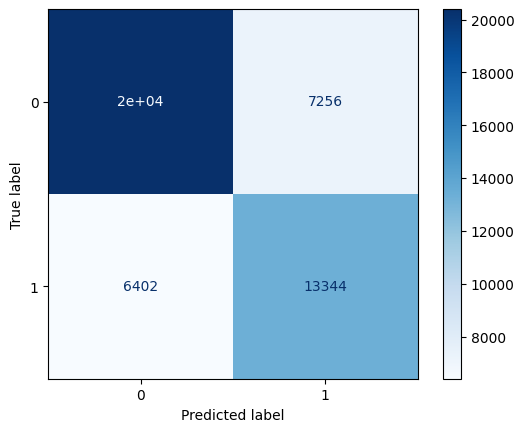

In [24]:
model = KNeighborsClassifier(metric='euclidean', n_neighbors=19, weights='distance')
model.fit(X_train_scaled, y_tomek)
y_pred_model = model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred_model)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()